In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pickle
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, regularizers
from tensorflow import keras as k
import random
from tqdm import tqdm
import shutil
import datetime, os

cwd = os.getcwd()
primary_dir = os.fsencode(cwd)

shutil.rmtree("/Users/joshking/Dropbox/Quantum/logs")
logs_base_dir = "/Users/joshking/Dropbox/Quantum/logs"
os.makedirs(logs_base_dir, exist_ok=True)
%reload_ext tensorboard
%tensorboard --logdir {logs_base_dir}
tensorboard_callback = k.callbacks.TensorBoard(log_dir=logs_base_dir,update_freq='epoch',embeddings_freq=0,
                                               profile_batch = 0)
writer = tf.summary.create_file_writer("/Users/joshking/Dropbox/Quantum/logs")

In [3]:
binary_dict = {0: 'No triangle', 1 : 'Bias triangle'}

In [4]:
def create_model(pixel_size=32,dense_layers = [32*2,32],drop_out=0.4,l2=0.0001):
    model = models.Sequential()
    model.add(layers.Conv2D(pixel_size, (3, 3), activation='relu', input_shape=(pixel_size, pixel_size, 1), padding="SAME"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(pixel_size*2, (3, 3), activation='relu', padding="SAME"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(pixel_size*2, (3, 3), activation='relu', padding="SAME"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(pixel_size*2, (3, 3), activation='relu', padding="SAME"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(pixel_size*2, (3, 3), activation='relu', padding="SAME"))

    model.add(layers.Flatten())
    for dense_layer in dense_layers:
        model.add(layers.Dense(dense_layer, activation='elu',kernel_regularizer=regularizers.l2(l2)))
        model.add(layers.Dropout(drop_out))
    
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

def compile_model(model):
    model.compile(optimizer='adam',
             loss='binary_crossentropy',
              metrics=['accuracy'])
    return model

def train_model(model,train_images,train_labels,test_images,test_labels,epochs,batch_size):
    history = model.fit(train_images,train_labels,shuffle=True, epochs=epochs, batch_size=batch_size, 
                        validation_data=(test_images,test_labels),callbacks=[tensorboard_callback])
    return model, history

def evaluate_model(model,history, test_images,test_labels):
    plt.clf()
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.0, 1.1])
    plt.legend(loc='lower right')
    plt.show()
    
    test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
    return test_loss, test_acc

def normalise(x, y):
    x = tf.image.per_image_standardization(x)
    return x, y

In [5]:
data_total = np.load('/Users/joshking/Documents/01Masters/Data/all_data_16_03_2020.npy')
labels_total = np.load('/Users/joshking/Documents/01Masters/Data/all_labels_16_03_2020.npy')
#/Users/joshking/Dropbox/Quantum/Triangles/normalised_data_matrices_train.npy
#/Users/joshking/Dropbox/Quantum/Triangles/normalised_data_labels_train.npy

positives_X = np.zeros(shape=(len(labels_total),32,32,1))
j=0
for i in range(len(labels_total)):
    if labels_total[i]==1:
        positives_X[j] = labels_total[i]
        j +=1
positives_X_2= np.delete(positives_X.copy(), np.s_[j:], 0)
print(j)

4646


In [6]:
def model_main(pixel_size=32,drop_out=0.4,l2=0.0001,epochs = 10,batch_size = 100):
    print('Trained on '+str(len(train_labels)))
    print('Validated on '+str(len(validate_labels)))

    model_binary_classifier = create_model(pixel_size=pixel_size,drop_out=drop_out,l2=l2)
    model_binary_classifier.summary()
    model_binary_classifier = compile_model(model_binary_classifier)

    val_loss, val_acc = train_model(model_binary_classifier,train_images_1,train_labels_1,validate_images_1,validate_labels_1,epochs,batch_size)


    true_positive = []
    false_positive = []
    true_negative = []
    false_negative = []
    for i in tqdm(range(len(validate_labels))):

            label = validate_labels[i][0]
            prediction = model_binary_classifier.predict(validate_images[i:i+1])
            if (prediction > 0.5):
                prediction = 1
            else:
                prediction = 0
            if (prediction == label):
                if (label == 1):
                    true_positive.append(validate_images[i:i+1])
                    prnt = "True positive"
                else:
                    true_negative.append(validate_images[i:i+1])
                    prnt = "True negative"
            else:
                if (label == 1):
                    false_negative.append(validate_images[i:i+1])
                    prnt = "False negative"
                else:
                    false_positive.append(validate_images[i:i+1])
                    prnt = "False positive"
            if (i<5):
                print('------------------------------------------')
                print(prnt)
                print('Label = ', binary_dict[label]," = ", label)
                print('prediction = ', prediction)
                plt.clf()
                plt.imshow(validate_images[i][:,:,0])
                plt.show()
        
    n_true_positive = np.shape(true_positive)[0]
    n_false_positive = np.shape(false_positive)[0]
    n_true_negative = np.shape(true_negative)[0]
    n_false_negative = np.shape(false_negative)[0]
    
    total_test = n_true_positive + n_false_positive + n_true_negative + n_false_negative

    percent_true_positive = 100 * n_true_positive/total_test
    percent_false_positive = 100 *n_false_positive/total_test
    percent_true_negative = 100 *n_true_negative/total_test
    percent_false_negative = 100 *n_false_negative/total_test

    return model_binary_classifier,percent_true_positive,percent_false_positive,percent_true_negative,percent_false_negative
    
    return


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Trained on 18652
Validated on 4663
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
_________

  0%|          | 0/4663 [00:00<?, ?it/s]

------------------------------------------
False negative
Label =  Bias triangle  =  1
prediction =  0


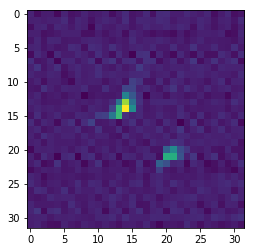

  0%|          | 1/4663 [00:00<31:11,  2.49it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


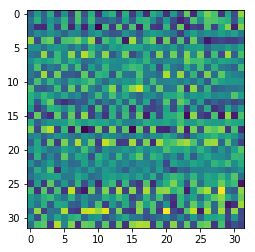

  0%|          | 2/4663 [00:00<25:21,  3.06it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


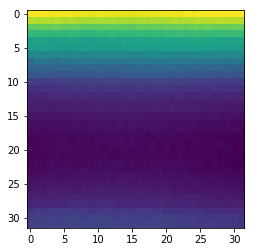

  0%|          | 3/4663 [00:00<22:53,  3.39it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


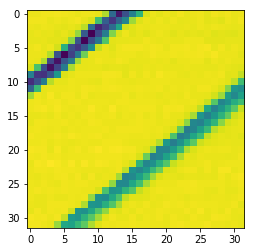

  0%|          | 4/4663 [00:00<19:38,  3.95it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


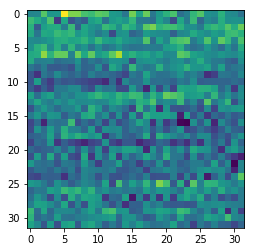

100%|██████████| 4663/4663 [03:06<00:00, 24.96it/s]


Trained on 18652
Validated on 4663
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)  

  0%|          | 0/4663 [00:00<?, ?it/s]

------------------------------------------
True positive
Label =  Bias triangle  =  1
prediction =  1


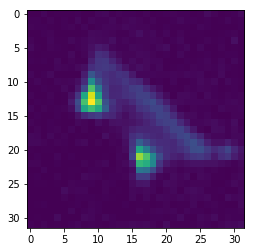

  0%|          | 1/4663 [00:00<20:51,  3.72it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


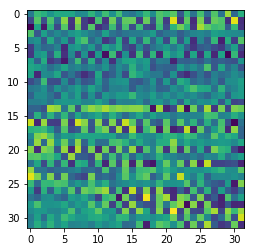

  0%|          | 2/4663 [00:00<18:06,  4.29it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


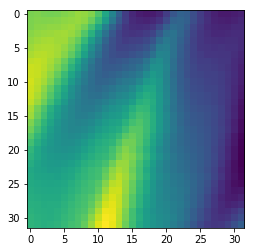

  0%|          | 3/4663 [00:00<16:08,  4.81it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


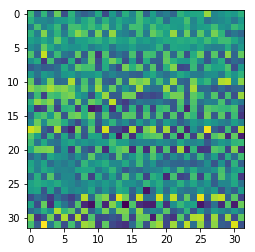

  0%|          | 4/4663 [00:00<14:47,  5.25it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


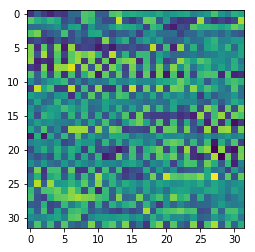

100%|██████████| 4663/4663 [03:13<00:00, 24.13it/s]


Trained on 18652
Validated on 4663
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_13 (Conv2D) 

  0%|          | 0/4663 [00:00<?, ?it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


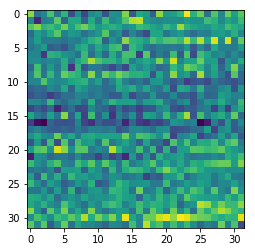

  0%|          | 1/4663 [00:00<29:29,  2.63it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


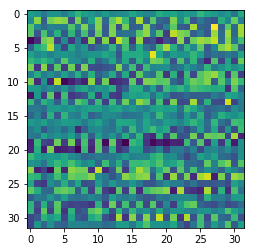

  0%|          | 2/4663 [00:00<24:57,  3.11it/s]

------------------------------------------
True positive
Label =  Bias triangle  =  1
prediction =  1


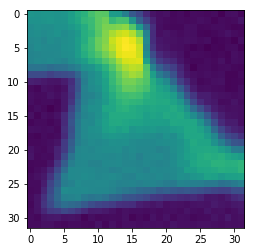

  0%|          | 3/4663 [00:00<21:12,  3.66it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


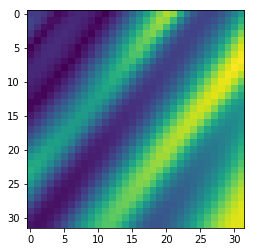

  0%|          | 4/4663 [00:00<18:29,  4.20it/s]

------------------------------------------
True negative
Label =  No triangle  =  0
prediction =  0


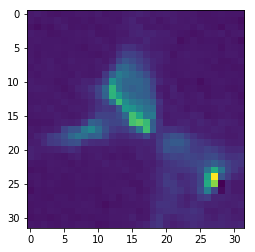

100%|██████████| 4663/4663 [04:09<00:00, 18.65it/s]  


In [7]:
perc_true_positive_tot = []
perc_false_positive_tot = []
perc_true_negative_tot = []
perc_false_negative_tot = []

for i in range(3):
    
    def myfunction():
        return 0.9
    z=np.arange(len(data_total))
    random.shuffle(z)
    images_copy=data_total.copy()
    images_shuffle=data_total.copy()
    labels_copy=labels_total.copy()
    labels_shuffle=labels_total.copy()
    for i in range(len(data_total)):
        images_shuffle[i]=images_copy[z[i]]
        labels_shuffle[i]=labels_copy[z[i]]
    images_shuffle,labels_shuffle = normalise(images_shuffle,labels_shuffle) #Data now shuffled
    
    val_split = 0.2
    val_set = np.int(val_split*np.shape(labels_shuffle)[0])
    train_images= np.array(images_shuffle[val_set:]).reshape(-1, 32, 32, 1)
    train_labels = np.array(labels_shuffle[val_set:]).reshape(-1, 1)
    validate_images = np.array(images_shuffle[:val_set]).reshape(-1, 32, 32, 1)
    validate_labels = np.array(labels_shuffle[:val_set]).reshape(-1, 1) #Data now reshaped
    train_images_squeeze=np.squeeze(train_images.copy())
    train_labels_squeeze=np.squeeze(train_labels.copy()) #Data now Squeezed

    positives_train_X = np.zeros(shape=(len(train_images),32,32,1))
    j=0
    for i in range(len(train_labels)):
        if train_labels[i]==1:
            positives_train_X[j] = train_images[i]
            j +=1
    positives_train_X_2= np.delete(positives_train_X.copy(), np.s_[j:], 0)
    doubled_positives_train_X_2=np.concatenate((positives_train_X_2,positives_train_X_2), axis=0)
    doubled_positives_train_Y = np.ones(shape=(len(doubled_positives_train_X_2),1),dtype=int)
    extra_train_images=np.concatenate((train_images.copy(),doubled_positives_train_X_2.copy()),axis=0)
    extra_train_labels=np.concatenate((train_labels.copy(),doubled_positives_train_Y.copy()),axis=0) #Now Upsampled
    
    train_images_1= extra_train_images
    train_labels_1 = extra_train_labels
    validate_images_1 = validate_images
    validate_labels_1 = validate_labels
    
    
    model_binary_classifier,percent_true_positive, percent_false_positive,percent_true_negative,percent_false_negative = model_main()
    
    perc_true_positive_tot.append(percent_true_positive)
    perc_false_positive_tot.append(percent_false_positive)
    perc_true_negative_tot.append(percent_true_negative)
    perc_false_negative_tot.append(percent_false_negative)

In [8]:
import csv
total_dict = {'1': perc_false_positive_tot, 
         '2': perc_false_negative_tot, 
         '3': perc_true_positive_tot, 
         '4': perc_true_negative_tot
        }
 
keys = sorted(total_dict.keys())
with open("CNN_CPCPCPCPC_upsampled_3runs_10epochs.csv", "w") as outfile:
    writer = csv.writer(outfile, delimiter = "\t")
    writer.writerow(keys)
    writer.writerows(zip(*[total_dict[key] for key in keys]))

In [9]:
# plt.plot(np.linspace(-7,0,7),n_true_positive,label='true_positive')
# plt.plot(np.linspace(-7,0,7),n_false_positive,label='false_positive') 
# plt.plot(np.linspace(-7,0,7),n_true_negative,label='true_negative') 
# plt.plot(np.linspace(-7,0,7),n_false_negative,label='false_negative') 
# plt.xlabel('log( L2 )')
# plt.ylabel('Percentage (%)')
# plt.legend()
# plt.show()
  

In [10]:
cwd = os.chdir(primary_dir)
model_binary_classifier.save('bias_triangle_binary_classifier.h5')
 

In [11]:
objects = ('true_positive','false_positive','true_negative','false_negative')
y_pos = np.arange(len(objects))
performance = [n_true_positive,n_false_positive,n_true_negative,n_false_negative]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('count')
plt.title('Confusion parameter')

plt.show()


NameError: name 'n_true_positive' is not defined

In [ ]:
print('Percent true positive  ',n_true_positive,'%')
print('Percent false positive  ',n_false_positive,'%')
print('Percent true negative  ',n_true_negative,'%')
print('Percent false negative  ',n_false_negative,'%')
# Percent true positive   11.213235294117647 %
# Percent false positive   0.49019607843137253 %
# Percent true negative   80.82107843137256 %
# Percent false negative   7.4754901960784315 %

In [ ]:
def myfunction():
    return 0.9
z=np.arange(len(data_total))
random.shuffle(z)
images_copy=data_total.copy()
images_shuffle=data_total.copy()
labels_copy=labels_total.copy()
labels_shuffle=labels_total.copy()
for i in range(len(data_total)):
    images_shuffle[i]=images_copy[z[i]]
    labels_shuffle[i]=labels_copy[z[i]]
images_shuffle,labels_shuffle = normalise(images_shuffle,labels_shuffle) #Data now shuffled



val_split = 0.2
val_set = np.int(val_split*np.shape(labels_shuffle)[0])
train_images= np.array(images_shuffle[val_set:]).reshape(-1, 32, 32, 1)
train_labels = np.array(labels_shuffle[val_set:]).reshape(-1, 1)
validate_images = np.array(images_shuffle[:val_set]).reshape(-1, 32, 32, 1)
validate_labels = np.array(labels_shuffle[:val_set]).reshape(-1, 1) #Data now reshaped
train_images_squeeze=np.squeeze(train_images.copy())
train_labels_squeeze=np.squeeze(train_labels.copy()) #Data now Squeezed

positives_train_X = np.zeros(shape=(len(train_images),32,32,1))
j=0
for i in range(len(train_labels)):
    if train_labels[i]==1:
        positives_train_X[j] = train_images[i]
        j +=1
        
T = len(train_labels)
print(T)
print(j)
print(3*j)
print(2*j + T)

print(j/T)
print(3*j/(T+2*j))


positives_train_X_2= np.delete(positives_train_X.copy(), np.s_[j:], 0)
doubled_positives_train_X_2=np.concatenate((positives_train_X_2,positives_train_X_2), axis=0)
doubled_positives_train_Y = np.ones(shape=(len(doubled_positives_train_X_2),1),dtype=int)
extra_train_images=np.concatenate((train_images.copy(),doubled_positives_train_X_2.copy()),axis=0)
extra_train_labels=np.concatenate((train_labels.copy(),doubled_positives_train_Y.copy()),axis=0) #Now Upsampled

train_images_1= extra_train_images
train_labels_1 = extra_train_labels
validate_images_1 = validate_images
validate_labels_1 = validate_labels